# 03 - Interactive Viz

In [1]:
#Useful imports
import pandas as pd
import folium
import json
import math
import numpy as np

import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

## Table of Contents
 
<div class="lev1"><a href="#1---Unemployment-rate-in-Europe">
<span class="toc-item-num">1&nbsp;&nbsp;</span>Unemployment rate in Europe</a></div>
 
<div class="lev1"><a href="#2---Unemployment-rate-in-Switzerland:-cantons">
<span class="toc-item-num">2&nbsp;&nbsp;</span>Unemployment rate in Switzerland: cantons</a></div>

<div class="lev1"><a href="#3---Unemployment-rate-in-Switzerland:-Swiss-vs-foreign-workers">
<span class="toc-item-num">3&nbsp;&nbsp;</span>Unemployment rate in Switzerland: Swiss vs foreign workers</a></div>

<div class="lev1"><a href="#4---Unemployment-rate-in-Switzerland:-areas-divided-by-the-Röstigraben">
<span class="toc-item-num">4&nbsp;&nbsp;</span>Unemployment rate in Switzerland: areas divided by the Röstigraben</a></div>


## 1 - Unemployment rate in Europe 

[source: [eurostat](http://ec.europa.eu/eurostat/data/database)]

By having a look at eurostat, we can find a file that seems perfect following this path :
> Database by theme >> Population and social conditions 
> Labour market >> Employment and unemployment >> LFS series - detailed quarterly survey results (from 1998 onwards) >> Total unemployment - LFS series >> lfsq_urgan.

It contains the unemployment rates by country of the two first quarters of 2017.

We manually downloaded the data: this is a .tsv file ('tab-separated values')

In [2]:
data  = pd.DataFrame.from_csv('./lfsq_urgan.tsv', sep='\t')
data = data.reset_index()

Here is a preview of what the data looks like:

In [3]:
data.head()

,"unit,sex,age,citizen,geo\time",2017Q2,2017Q1,2016Q4,2016Q3,2016Q2,2016Q1,2015Q4,2015Q3,2015Q2,...,2000Q2,2000Q1,1999Q4,1999Q3,1999Q2,1999Q1,1998Q4,1998Q3,1998Q2,1998Q1
0,"PC,F,Y15-19,EU15_FOR,AT",: u,: u,: u,: u,: u,: u,: u,:,:,...,:,: u,:,:,:,:,:,:,:,:
1,"PC,F,Y15-19,EU15_FOR,BE",: u,: bu,:,: u,:,:,: u,:,:,...,: u,: u,: u,:,:,: b,:,:,: u,:
2,"PC,F,Y15-19,EU15_FOR,BG",:,:,:,:,:,:,:,:,:,...,:,:,:,:,:,:,:,:,:,:
3,"PC,F,Y15-19,EU15_FOR,CH",18.5 u,27.7 u,16.5 u,27.3 u,17.7 u,10.4 u,27.1 u,18.6 u,21.2 u,...,: u,:,:,:,: u,:,:,:,: u,:
4,"PC,F,Y15-19,EU15_FOR,CY",: u,: u,:,: u,: u,: u,:,: u,: u,...,: u,:,:,:,:,:,:,:,:,:


We see that the first column groups multiple features together: 'unit', 'sex', 'age', 'citizen' and 'geo'.
Therefore, we split it into multiple columns so that each feature can be handled more easily.

In [4]:
data['unit'],data['sex'],data['age'],data['citizen'],data['geo'] = data[data.columns[0]].str.split(',').str

Next we list all the possible age intervals present in this file:

In [5]:
print(data['age'].unique())

['Y15-19' 'Y15-24' 'Y15-39' 'Y15-59' 'Y15-64' 'Y15-74' 'Y20-24' 'Y20-64'
 'Y25-29' 'Y25-49' 'Y25-54' 'Y25-59' 'Y25-64' 'Y25-74' 'Y30-34' 'Y35-39'
 'Y40-44' 'Y40-59' 'Y40-64' 'Y45-49' 'Y50-54' 'Y50-59' 'Y50-64' 'Y50-74'
 'Y55-59' 'Y55-64' 'Y60-64' 'Y65-69' 'Y65-74' 'Y70-74']


For our analysis, we choose to consider entries with an age interval of 'Y20-64': before 20 years old, most people have not worked yet and are not considered as unemployed, and around 64, people have retired or start to.

In [6]:
print(data['citizen'].unique())

['EU15_FOR' 'EU27_FOR' 'EU28_FOR' 'FOR' 'NAT' 'NEU15_FOR' 'NEU27_FOR'
 'NEU28_FOR' 'NRP' 'TOTAL']


When considering the country of citizenship ('citizen'), we will use the entries having the value 'TOTAL'.

In [7]:
print(data['sex'].unique())

['F' 'M' 'T']


'F' stands for 'Female', 'M' for 'Male' and 'T' for 'Total': we will only consider entries with the 'T' value, which regroups the percentages for both men and women.

Here is a resume of the meaning of each column and the possible values:

* **unit**: the unit of the data,
> here, 'PC' indicated the data is a percentage

* **sex**: the sex of the individuals in the considered population

| Code | Description  |   
| :----| :------------| 
| F    | Females      |
| M    | Males        |
| T    | Total        |

* **age**: the age of the individuals in the considered population (the ages are grouped in intervals of various size, e.g. Y15-19: from 15 to 19 years):   

| Age interval |
| :------------|
| Y15-19 Y15-24 Y15-39 Y15-59 Y15-64 Y15-74 |
| Y20-24 Y20-64 |
| Y25-29 Y25-49 Y25-54 Y25-59 Y25-64 Y25-74 |
| Y30-34  |
| Y35-39  |
| Y40-44 Y40-59 Y40-64 |
| Y45-49 |
| Y50-54 Y50-59 Y50-64 Y50-74 |
| Y55-59 Y55-64 |
| Y60-64 |
| Y65-69 Y65-74 |
| Y70-74 |
    
* **citizen**: the country of citizenship of the individuals on the considered population

| Code       | Description                              |   
| :----------| :----------------------------------------| 
| EU28_FOR   | EU28 countries except reporting country  |
| EU27_FOR   | EU27 countries except reporting country  |
| EU15_FOR   | EU15 countires except reporting country  |
| NEU28_FOR  | Non-EU28 countries nor reporting country | 
| NEU27_FOR  | Non-EU27 countries nor reporting country |
| NEU25_FOR  | Non-EU15 countries nor reporting country |  
| FOR        | Foreign country                          |
| NAT        | Reporting country                        |
| TOTAL      | Total                                    |
| NRP        | No response                              |

* **geo**: the country of residence of the individuals in the considered population


| Code   | Description                   | Code   | Description     | Code   | Description    |   
| :------| :-----------------------------| :------| :---------------|:-------| :--------------|
| EU28   | European Union (28 countries) | DE     | Germany         | L      | Latvia         |
| EU27   | European Union (27 countries) | EE     | Estoania        | MK     | Macedonia      |
| EU15   | European Union (15 countries) | EL     | Greece          | MT     | Malta          |
| EA19   | Euro area (19 countries)      | ES     | Spain           | NL     | Netherlands    |
| EA18   | Euro area (18 countries)      | FI     | Finland         | NO     | Norway         |
| EA17   | Euro area (17 countres)       | FR     | France          | PL     | Poland         |
| AT     | Austria                       | HR     | Croatia         | PT     | Portugal       |
| BE     | Belgium                       | HU     | Hungary         | RO     | Romania        |
| BG     | Bulgaria                      | IE     | Ireland         | SE     | Sweden         |
| CH     | Switzerland                   | IS     | Iceland         | SI     | Slovenia       |
| CV     | Cyprus                        | IT     | Italy           | SK     | Slovakia       |
| CZ     | Czech Republik                | LT     | Lithuania       | TR     | Turkey         |
| DK     | Denmark                       | LU     | Luxembourg      | UK     | United Kingdom |



* **time**: the year and quadrimester for which the data applies
> e.g. '2017Q2': the second quadrimester of the year 2017

We will show on the map only the latest data, that is, from the second quadrimester of 2017 ('2017Q2').

Next we filter the data by keeping only the entries we are interested in:

In [8]:
datafilter = data[(data["age"]=="Y20-64") 
                & (data["citizen"]=="TOTAL") 
                & (data["sex"]=="T") ].copy()
                                                                          
#convert to numeric                                                                          
datafilter["2017Q2 "] = pd.to_numeric(datafilter["2017Q2 "],errors="coerce")
# keep not null
datafilter = datafilter[datafilter["2017Q2 "].notnull()]
#remove global data on europe? how to print them on the map ?
datafilter = datafilter[~(datafilter["geo"].str.startswith("EU") | datafilter["geo"].str.startswith("EA") )]

In [9]:
print(datafilter["geo"].unique().shape)
print(datafilter["geo"].unique())

(33,)
['AT' 'BE' 'BG' 'CH' 'CY' 'CZ' 'DE' 'DK' 'EE' 'EL' 'ES' 'FI' 'FR' 'HR' 'HU'
 'IE' 'IS' 'IT' 'LT' 'LU' 'LV' 'MK' 'MT' 'NL' 'NO' 'PL' 'PT' 'RO' 'SE' 'SI'
 'SK' 'TR' 'UK']


We have a total of 33 countries. But there are only **?27?** countries in the UE.

In [10]:
state_geo_path = r'./topojson/europe.topojson.json'
for f in json.load(open(state_geo_path))["objects"]["europe"]["geometries"]:
    print(f["id"],"=",f['properties']['NAME'],)

AZ = Azerbaijan
AL = Albania
AM = Armenia
BA = Bosnia and Herzegovina
BG = Bulgaria
CY = Cyprus
DK = Denmark
IE = Ireland
EE = Estonia
AT = Austria
CZ = Czech Republic
FI = Finland
FR = France
GE = Georgia
DE = Germany
GR = Greece
HR = Croatia
HU = Hungary
IS = Iceland
IL = Israel
IT = Italy
LV = Latvia
BY = Belarus
LT = Lithuania
SK = Slovakia
LI = Liechtenstein
MK = The former Yugoslav Republic of Macedonia
MT = Malta
BE = Belgium
FO = Faroe Islands
AD = Andorra
LU = Luxembourg
MC = Monaco
ME = Montenegro
NL = Netherlands
NO = Norway
PL = Poland
PT = Portugal
RO = Romania
MD = Republic of Moldova
SI = Slovenia
ES = Spain
SE = Sweden
CH = Switzerland
TR = Turkey
GB = United Kingdom
UA = Ukraine
SM = San Marino
RS = Serbia
VA = Holy See (Vatican City)
RU = Russia


We do not keep the countries in the json overlay for which we do not have any data from Eurostat (e.g. Azerbaijan, Monaco, Russia, ...), because we do not want them to get displayed on the map.

In [11]:
with open(state_geo_path) as json_data:
    europe_topojson = json.load(json_data)

#access the list of countries in the json
europe_topojson_list = europe_topojson['objects']['europe']['geometries']

#get the country codes in the eurostat data (ISO 3166-1 alpha-2 convention)
european_country_codes = datafilter['geo'].unique()

#filter out the countries whose country code to not appear in the eurostat country codes
non_eurostat_countries = [c for c in europe_topojson_list if (c['id'] not in european_country_codes)]
eurostat_topojson_list = [c for c in europe_topojson_list if c not in non_eurostat_countries]

#assign the updated country list to the new json overlay
eurostat_topojson = europe_topojson
eurostat_topojson['objects']['europe']['geometries'] = eurostat_topojson_list

The *topojson/europe.topojson.json* overlay uses the international ISO 3166-1 alpha-2 convention. 
However, there are two countries whose 2-letter european country code differ from this alpha-2 convention: Greece and the United Kingdom, which are mapped to 'EL' and 'UK' instead of 'GR' and 'GB' respectively.
We decided to map them using the european convention, because this is the one used by the Eurostat institution.

Note: the european convention uses the native name of the country for assigning the country code, not the english one.

In [12]:
datafilter.loc[datafilter['geo']=='UK', 'geo'] = 'GB'
datafilter.loc[datafilter['geo']=='EL', 'geo'] = 'GR'

We find the quartile in order to estalish a scale:

In [13]:
min_unemployment_rate = datafilter['2017Q2 '].min()
max_unemployment_rate = datafilter['2017Q2 '].max()
print('minimum unemployment rate: {:8.2f} %'.format(min_unemployment_rate))
print('maximum unemployment rate: {:8.2f} %'.format(max_unemployment_rate))

minimum unemployment rate:     2.60 %
maximum unemployment rate:    22.40 %


In [14]:
scale = list( datafilter['2017Q2 '].quantile([x * 1/5 for x in range(1, 5)]).values)
print([x * 1/5 for x in range(1, 5)])
scale = [math.floor(min_unemployment_rate)] + scale + [math.ceil(max_unemployment_rate)]
print(scale)

[0.2, 0.4, 0.6, 0.8]
[2, 4.3200000000000003, 5.2800000000000002, 7.0199999999999996, 9.5000000000000018, 23]


In [15]:
lausanne_coord = [46.519962, 6.633597]
m_europe = folium.Map(location=lausanne_coord, tiles='cartodbpositron', zoom_start=4)

m_europe.choropleth(geo_data=eurostat_topojson, 
                    data=datafilter,
                    columns=['geo', '2017Q2 '],
                    threshold_scale=scale,
                    key_on='id',
                    topojson='objects.europe',
                    fill_color='YlOrBr', fill_opacity=1, line_opacity=0.2,
                    legend_name='Unemployment rate in european countries (%)')

In [16]:
m_europe

### Observations

...

## 2 - Unemployment rate in Switzerland: cantons

[source: [amstat](https://www.amstat.ch/v2/index.jsp)]

We first load the data we manually downloaded from the [amstat](https://www.amstat.ch/v2/index.jsp) website:

In [17]:
#dataCSV  = pd.DataFrame.from_csv('./tchch.csv',encoding='utf-16', sep='\t')
dataCSV  = pd.DataFrame.from_csv('./2_1 Taux de chômage.csv',encoding='utf-16', sep='\t')

In [188]:
#code for 'tchch.csv'
#data = dataCSV.copy()
#data["canton"],data["nat"],data["nothing"],data["taux"],data["nothing"],data["nothing"],data["nothing"]= data.index.str.split(",").str
#data = data.iloc[2:-1]
#data.drop("nothing",axis=1,inplace=True)
#data.reset_index(drop=True,inplace=True)
#data["taux"] = pd.to_numeric(data["taux"].str.replace('"', ''))
#data["nat"] = (data["nat"].str.replace('"', ''))

In [19]:
data = dataCSV.copy()

data = data.iloc[2:-1]

data['canton'] = list(data.index.str.split(",").str)[0]
data['unemployment rate'] = list(data.index.str.split(",").str)[2]
data['unemployment rate'] = pd.to_numeric(data['unemployment rate'].str.replace('"', ''))

data.reset_index(drop=True,inplace=True)

In [187]:
data.head()

,canton,nationality,age group,number of unemployed,id
0,Zurich,foreigners,1.0,1015,ZH
1,Zurich,foreigners,2.0,8846,ZH
2,Zurich,foreigners,3.0,2250,ZH
3,Zurich,swiss,1.0,2405,ZH
4,Zurich,swiss,2.0,8207,ZH


We will use a dictionary mapping the canton code to the canton names used by [amstat](https://www.amstat.ch/v2/index.jsp). This allows use to map each canton's entry to the cantons in the json overlay for Switzerland's topology without having to deal with the translation of canton's names between different languages.

In [21]:
amstat_canton_code_mapping = {'Argovie':'AG',
                              'Appenzell Rhodes-Extérieures':'AR',
                              'Appenzell Rhodes-Intérieures':'AI',
                              'Berne':'BE',
                              'Bâle-Campagne':'BL', 
                              'Bâle-Ville':'BS',
                              'Fribourg':'FR',
                              'Genève':'GE',
                              'Glaris':'GL',
                              'Grisons':'GR',
                              'Jura':'JU',
                              'Lucerne':'LU',                              
                              'Obwald':'OW', 
                              'Neuchâtel':'NE',
                              'Nidwald':'NW',
                              'St-Gall':'SG',
                              'Schaffhouse':'SH',
                              'Soleure':'SO',
                              'Schwyz':'SZ',
                              'Thurgovie':'TG',
                              'Tessin':'TI',                            
                              'Uri':'UR',
                              'Vaud':'VD',
                              'Valais':'VS',
                              'Zoug':'ZG',
                              'Zurich':'ZH'}

In [22]:
data['id'] = data['canton'].map(amstat_canton_code_mapping)
data

,canton,unemployment rate,id
0,Zurich,3.3,ZH
1,Berne,2.4,BE
2,Lucerne,1.7,LU
3,Uri,0.6,UR
4,Schwyz,1.7,SZ
5,Obwald,0.7,OW
6,Nidwald,1.0,NW
7,Glaris,1.8,GL
8,Zoug,2.3,ZG
9,Fribourg,2.7,FR


In [23]:
lausanne_coord = [46.519962, 6.633597]
state_geo_path = r'./topojson/ch-cantons.topojson.json'
for f in json.load(open(state_geo_path))["objects"]["cantons"]["geometries"]:
    print(f["id"],"=",f['properties']['name'],)

ZH = ZÃ¼rich
BE = Bern/Berne
LU = Luzern
UR = Uri
SZ = Schwyz
OW = Obwalden
NW = Nidwalden
GL = Glarus
ZG = Zug
FR = Fribourg
SO = Solothurn
BS = Basel-Stadt
BL = Basel-Landschaft
SH = Schaffhausen
AR = Appenzell Ausserrhoden
AI = Appenzell Innerrhoden
SG = St. Gallen
GR = GraubÃ¼nden/Grigioni
AG = Aargau
TG = Thurgau
TI = Ticino
VD = Vaud
VS = Valais/Wallis
NE = NeuchÃ¢tel
GE = GenÃ¨ve
JU = Jura


In [24]:
m_swiss = folium.Map(location=lausanne_coord, tiles='cartodbpositron', zoom_start=7)
m_swiss.choropleth(geo_data=open(state_geo_path), data=data,
             columns=['id', 'unemployment rate'],
             key_on='id',
             topojson='objects.cantons',
             fill_color='YlOrRd', fill_opacity=1, line_opacity=0.2,
             legend_name='Percentage of unemployment in Switzerland per canton (%)')

In [25]:
m_swiss

## 3 - Unemployment rate in Switzerland: Swiss vs foreign workers

[source: [amstat](https://www.amstat.ch/v2/index.jsp)]

Now we repeat the exercise for Switzerland but distinguishing Swiss workers from foreign ones.

> *The Economic Secretary (SECO) releases a monthly report on the state of the employment market. In the latest report (September 2017), it is noted that there is a discrepancy between the unemployment rates for foreign (5.1%) and Swiss (2.2%) workers.*

### 3.1 - Difference in unemployment on two maps
*Show the difference in unemployment rates between the two categories in each canton on a Choropleth map (hint The easy way is to show two separate maps, but can you think of something better ?). *


In [26]:
dataCSV = pd.DataFrame.from_csv('./2_1 Taux de chômage_nat.csv',encoding='utf-16', sep='\t')
dataCSV.head()

""
2.1 Taux de chômage
"Canton,""Nationalité"",""Mois"",""Septembre 2017"",""Septembre 2017"",""Septembre 2017"",""Total"",""Total"",""Total"""
", ,""Mesures"",""Taux de chômage"",""Coefficients de variation"",""Chômeurs inscrits"",""Taux de chômage"",""Coefficients de variation"",""Chômeurs inscrits"""
"Zurich,""Etrangers"",,""5.3"",""A"",""12'111"",""5.3"",""A"",""12'111"""
"Zurich,""Suisses"",,""2.5"",""A"",""15'114"",""2.5"",""A"",""15'114"""
"Berne,""Etrangers"",,""5.5"",""A"",""4'900"",""5.5"",""A"",""4'900"""


In [27]:
#Drop header and total rows
data = dataCSV.copy()
data = data.iloc[2:-1]

data['canton'] = list(data.index.str.split(",").str)[0]
data['nationalité'] = list(data.index.str.split(",").str)[1]
data['unemployment rate'] = list(data.index.str.split(",").str)[3]
data['unemployment rate'] = pd.to_numeric(data['unemployment rate'].str.replace('"', ''))

data.reset_index(drop=True,inplace=True)

data['id'] = data['canton'].map(amstat_canton_code_mapping)
data.head()

,canton,nationalité,unemployment rate,id
0,Zurich,"""Etrangers""",5.3,ZH
1,Zurich,"""Suisses""",2.5,ZH
2,Berne,"""Etrangers""",5.5,BE
3,Berne,"""Suisses""",1.8,BE
4,Lucerne,"""Etrangers""",3.9,LU


### 3.2 - Difference in unemployment on one map

In [28]:
data_difference = data.copy()
data_difference = data_difference.pivot(index='canton', columns='nationalité', values='unemployment rate')
data_difference.reset_index(inplace=True)
data_difference.columns = ['canton', 'foreigners', 'swiss']
data_difference['id'] = data_difference['canton'].map(amstat_canton_code_mapping)
data_difference

,canton,foreigners,swiss,id
0,Appenzell Rhodes-Extérieures,3.4,1.4,AR
1,Appenzell Rhodes-Intérieures,2.0,0.5,AI
2,Argovie,5.6,2.1,AG
3,Berne,5.5,1.8,BE
4,Bâle-Campagne,4.8,2.2,BL
5,Bâle-Ville,4.6,2.8,BS
6,Fribourg,5.0,2.0,FR
7,Genève,5.7,4.8,GE
8,Glaris,3.4,1.4,GL
9,Grisons,2.3,0.7,GR


In [29]:
import branca.colormap as cm 

cm.linear.PuBu.to_step(12)

step = cm.StepColormap(
    ['green', 'yellow', 'red'],
    vmin=3, vmax=10,
    index=[3, 4, 8, 10],
    caption='step'
)

open(state_geo_path)


<_io.TextIOWrapper name='./topojson/ch-cantons.topojson.json' mode='r' encoding='cp1252'>

In [30]:
scale_swiss = list(data_difference['swiss'].quantile([x * 1/5 for x in range(1, 5)]).values)
scale_swiss = [math.floor(data_difference['swiss'].min())] + scale_swiss + [math.ceil(data_difference['swiss'].max())]

scale_foreigners = list(data_difference['foreigners'].quantile([x * 1/5 for x in range(1, 5)]).values)
scale_foreigners = [math.floor(data_difference['foreigners'].min())] + scale_foreigners + [math.ceil(data_difference['foreigners'].max())]

map_swiss_foreigners_difference = folium.Map(location=lausanne_coord, tiles='cartodbpositron', zoom_start=7)
map_swiss_foreigners_difference.choropleth(geo_data=open(state_geo_path), data=data_difference,
             columns=['id', 'swiss'],
             key_on='id',
             topojson='objects.cantons',
             fill_color='PuRd', fill_opacity=0.9, line_opacity=0.2,
             threshold_scale=scale_swiss,
             legend_name='Unemployment rate for Swiss (%)',
             highlight=True)

map_swiss_foreigners_difference.choropleth(geo_data=open(state_geo_path), data=data_difference,
             columns=['id', 'foreigners'],
             key_on='id',
             topojson='objects.cantons',
             fill_color='PuBu', fill_opacity=0.6, line_opacity=0.2,
             threshold_scale=scale_foreigners,
             legend_name='Unemployment rate for foreigners (%)',
             highlight=True)

map_swiss_foreigners_difference

In [31]:
unemployment_swiss = data_difference.set_index('id')['swiss']
unemployment_foreigners = data_difference.set_index('id')['foreigners']

In [32]:
m = folium.Map(location=lausanne_coord, tiles='cartodbpositron', zoom_start=7)

colormap_1 = cm.LinearColormap(
    ['#e8e8e8', '#64acbe'],
    vmin=0, vmax=math.ceil(unemployment_swiss.max())
)
colormap_1 = colormap_1.to_step(6)
colormap_1.caption = 'Unemployment rate among Swiss (%)'

folium.TopoJson(
    open(state_geo_path),
    'objects.cantons',
    style_function=lambda feature: {
        'fillColor': colormap_1(unemployment_swiss[feature['id']]),
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillOpacity': 0.7
    }
).add_to(m)

m.add_child(colormap_1)

m

In [33]:
m = folium.Map(location=lausanne_coord, tiles='cartodbpositron', zoom_start=7)


colormap_2 = cm.LinearColormap(
    ['#e8e8e8', '#c85a5a'],
    vmin=0, vmax=math.ceil(unemployment_foreigners.max())
)
colormap_2 = colormap_2.to_step(6)

colormap_2.caption = 'Unemployment rate among foreigners (%)'

folium.TopoJson(
    open(state_geo_path),
    'objects.cantons',
    style_function=lambda feature: {
        'fillColor': colormap_2(unemployment_foreigners[feature['id']]),
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillOpacity': 0.7
    }
).add_to(m)

m

m.add_child(colormap_2)

In [34]:
m = folium.Map(location=lausanne_coord, tiles='cartodbpositron', zoom_start=7)

folium.TopoJson(
    open(state_geo_path),
    'objects.cantons',
    style_function=lambda feature: {
        'fillColor': colormap_1(unemployment_swiss[feature['id']]),
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillOpacity': 1.0
    }
).add_to(m)

folium.TopoJson(
    open(state_geo_path),
    'objects.cantons',
    style_function=lambda feature: {
        'fillColor': colormap_2(unemployment_foreigners[feature['id']]),
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillOpacity': 0.8
    }
).add_to(m)

m.add_child(colormap_1)
m.add_child(colormap_2)

m

In [35]:
tercile_swiss_1 = list(data_difference['swiss'].sort_values())[int(np.floor(len(data_difference['swiss'])/3))]
tercile_swiss_2 = list(data_difference['swiss'].sort_values())[int(np.floor(len(data_difference['swiss'])*2/3))]

tercile_foreigners_1 = list(data_difference['foreigners'].sort_values())[int(np.floor(len(data_difference['foreigners'])/3))]
tercile_foreigners_2 = list(data_difference['foreigners'].sort_values())[int(np.floor(len(data_difference['foreigners'])*2/3))]

print('swiss:', tercile_swiss_1, tercile_swiss_2)
print('foreigners:', tercile_foreigners_1, tercile_foreigners_2)

swiss: 1.4 2.2
foreigners: 3.9 5.0


In [36]:
def non_linear_scale(df):     
    
    if(df['swiss'] < tercile_swiss_1):
        if(df['foreigners'] < tercile_foreigners_1):
            return 1
        elif(tercile_foreigners_1 <= df['foreigners'] and df['foreigners'] < tercile_foreigners_2):
            return 2
        else:
            return 3
    elif(tercile_swiss_1 <= df['swiss'] < tercile_swiss_2):
        if(df['foreigners'] < tercile_foreigners_1):
            return 4
        elif(tercile_foreigners_1 <= df['foreigners'] and df['foreigners'] < tercile_foreigners_2):
            return 5
        else:
            return 6
    else:
        if(df['foreigners'] < tercile_foreigners_1):
            return 7
        elif(tercile_foreigners_1 <= df['foreigners'] and df['foreigners'] < tercile_foreigners_2):
            return 8
        else:
            return 9   

data_difference['combined'] = data_difference.apply(non_linear_scale, axis=1)
#data_difference
#print(data_difference['combined'].unique())

In [44]:
#some possible colour grids:
grid_1 = ['#dddddd', '#7bb3d1', '#016eae',
          '#dd7c8a', '#8d6c8f', '#4a4779',
          '#cc0024', '#8a274a', '#4b264d']
#http://tolomaps.tumblr.com/post/131671267233/creating-a-bivariate-choropleth-color-scheme
grid_2 = ['#e8e8e8', '#e4d9ac', '#c8b35a',
          '#cbb8d7', '#c8ada0', '#af8e53',
          '#9972af', '#976b82', '#804d36']
grid_3 = ['#e8e8e8', '#e4acac', '#c85a5a', 
          '#b0d5df', '#ad9ea5', '#985356',
          '#64acbe', '#627f8c', '#574249']
#http://www.joshuastevens.net/cartography/make-a-bivariate-choropleth-map/


In [45]:
colormap_3 = cm.StepColormap(
    grid_1,
    vmin=0, vmax=9,
    index=[0, 1, 2, 3, 4, 5, 6, 7, 8],
    caption='bivariate_like'
)

colormap_3.caption = 'Unemployment rate'

unemployment = data_difference.set_index('id')['combined']

m = folium.Map(location=lausanne_coord, tiles='cartodbpositron', zoom_start=7)

folium.TopoJson(
    open(state_geo_path),
    'objects.cantons',
    style_function=lambda feature: {
        'fillColor': colormap_3(unemployment[feature['id']]),
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillOpacity': 1.0
    }
).add_to(m)

#m.add_child(colormap_3)

m

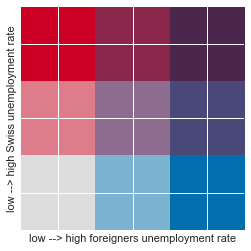

In [46]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

matrix = [[7,8,9],[4,5,6],[1,2,3]]
plt.matshow(matrix, cmap=ListedColormap(grid_1))
plt.xlabel('low --> high foreigners unemployment rate')
plt.ylabel('low --> high Swiss unemployment rate')
plt.tick_params(
    axis='both',          
    which='both',           
    top='off', 
    left='off',
    labeltop='off', 
    labelleft='off')
plt.show()

### Observations 
*Where are the differences most visible ? Why do you think that is ?*

### 3.3 - Differences between age groups 
Now let's refine the analysis by adding the differences between age groups. As you may have guessed it is nearly impossible to plot so many variables on a map. Make a bar plot, which is a better suited visualization tool for this type of multivariate data.


In [47]:
dataCSV = pd.DataFrame.from_csv('./unemployment_rate_per_canton_nationality_age_group.csv',encoding='utf-16', sep='\t')
dataCSV.head()

""
1.1 Chômeurs et demandeurs d'emploi selon divers critères
"Canton,""Nationalité"",""Classes d'âge 15-24, 25-49, 50 ans et plus"",,""Mois"",""Septembre 2017"""
", , ,,""Mesures"",""Chômeurs inscrits"""
"Zurich,""Etrangers"",""1"",""15-24 ans"",,""1'015"""
"Zurich,""Etrangers"",""2"",""25-49 ans"",,""8'846"""
"Zurich,""Etrangers"",""3"",""50 ans et plus"",,""2'250"""


It requires a bit of work to import the data from the csv file in a clean and nice pandas dataframe. In afct, we will:

* drop the header
* remove any kind of quotation marks 
* drop the rows indicating the 'Total' number of unemployed individuals
* replace entries written in french by an english equivalent
* add an column indicating the canton code

In [229]:
data = dataCSV.copy()
#drop the header
data = data.iloc[2:-1]

data['canton'] = list(data.index.str.split(",").str)[0]

data['nationality'] = list(data.index.str.split(",").str)[1]
data['nationality'] = data['nationality'].str.replace('"', '')
data['nationality'] = data['nationality'].str.replace('Suisses', 'swiss')
data['nationality'] = data['nationality'].str.replace('Etrangers', 'foreigners')
data = data[data['nationality'] != 'Total']

data['age group'] = list(data.index.str.split(",").str)[2]
data['age group'] = data['age group'].str.replace('"', '')
data = data[data['age group'] != 'Total']
data['age group'] = pd.to_numeric(data['age group'])

data['number of unemployed'] = list(data.index.str.split(",").str)[5]
data['number of unemployed'] = data['number of unemployed'].str.replace('"', '')
data['number of unemployed'] = data['number of unemployed'].str.replace('\'', '')
data['number of unemployed'] = pd.to_numeric(data['number of unemployed'])

#age_group_mapping = {'1':'15-24', '2':'25-49', '3':'>50'}

data.reset_index(drop=True,inplace=True)

data['id'] = data['canton'].map(amstat_canton_code_mapping)
data.head(10)

,canton,nationality,age group,number of unemployed,id
0,Zurich,foreigners,1,1015,ZH
1,Zurich,foreigners,2,8846,ZH
2,Zurich,foreigners,3,2250,ZH
3,Zurich,swiss,1,2405,ZH
4,Zurich,swiss,2,8207,ZH
5,Zurich,swiss,3,4502,ZH
6,Berne,foreigners,1,597,BE
7,Berne,foreigners,2,3316,BE
8,Berne,foreigners,3,987,BE
9,Berne,swiss,1,1406,BE


In order to create a bar plot displaying the number of unemployed individuals per canton, nationality and age group, we split the previous dataframe into two dataframes: one regrouping the entries about Swiss individuals, the other the entries about foreigners.

In [231]:
table_swiss = pd.pivot_table(data, values='number of unemployed', index=['canton', 'nationality'], columns=['age group'])
table_swiss = table_swiss.xs('swiss', axis=0, level=1, drop_level=False)
table_swiss.head()

,age group,1,2,3
canton,nationality,,,
Appenzell Rhodes-Extérieures,swiss,44,151,149
Appenzell Rhodes-Intérieures,swiss,10,14,15
Argovie,swiss,958,2792,1962
Berne,swiss,1406,4457,2895
Bâle-Campagne,swiss,359,1270,857


In [232]:
table_foreigners = pd.pivot_table(data, values='number of unemployed', index=['canton', 'nationality'], columns=['age group'])
table_foreigners = table_foreigners.xs('foreigners', axis=0, level=1, drop_level=False)
table_foreigners.head()

,age group,1,2,3
canton,nationality,,,
Appenzell Rhodes-Extérieures,foreigners,21,108,50
Appenzell Rhodes-Intérieures,foreigners,6,10,7
Argovie,foreigners,597,3270,1105
Berne,foreigners,597,3316,987
Bâle-Campagne,foreigners,165,1089,342


In [236]:
def plot_clustered_stacked(df_all, title):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
"""
    
    n_df = len(df_all)
    n_col = len(df_all[0].columns) 
    n_ind = len(df_all[0].index)
    
    ax = plt.subplot(111)
    
    #plot each dataframe
    for df in df_all: 
        ax = df.plot(kind='bar',
                      linewidth=1.,
                      edgecolor='#e0e0e0',
                      color=['#a6cee3', '#1f78b4', '#b2df8a'],
                      stacked=True,
                      ax=ax,
                      legend=False,
                      grid=False,
                      figsize=(18,8),
                      )
        
    #position the bars    
    h,l = ax.get_legend_handles_labels() 
    for i in range(0, n_df * n_col, n_col): 
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: 
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_width(1 / float(n_df + 1))

    ax.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    ax.set_xticklabels(df.index, rotation = 90)
    
    ax.set_xlabel('canton')
    ax.set_ylabel('number of unemployed')
    ax.set_title(title)

    #add a legend
    ax.legend(h[:n_col], l[:n_col], loc=[1.01, 0.5])
   
    return ax

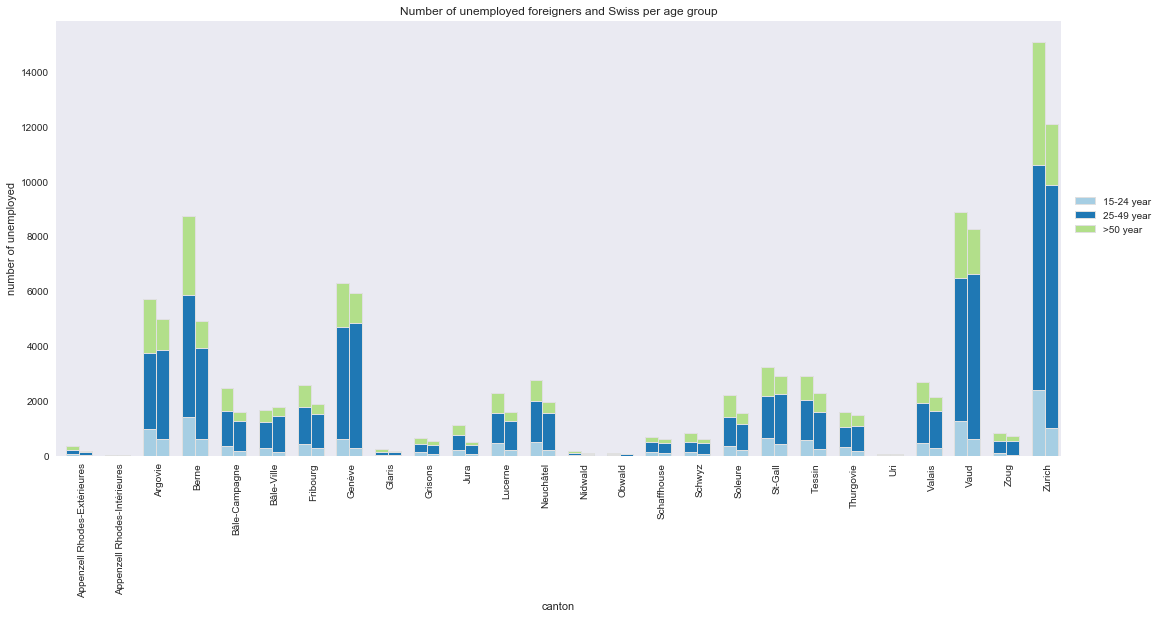

In [237]:
column_names = ['15-24 year', '25-49 year', '>50 year']

df_swiss = pd.DataFrame(table_swiss.values,
                   index=sorted(data['canton'].unique()),
                   columns=column_names)

df_foreigners = pd.DataFrame(table_foreigners.values,
                   index=sorted(data['canton'].unique()),
                   columns=column_names)

plot_clustered_stacked([df_swiss, df_foreigners],
                       'Number of unemployed foreigners and Swiss per age group');

In [ ]:
#TODO: find percentage of foreigners and swiss per canton (numbers in bar plot are absolute)

## 4 - Unemployment rate in Switzerland: areas divided by the Röstigraben
[source: [amstat](https://www.amstat.ch/v2/index.jsp)]